In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.fft import fft2, fftshift, ifftshift

from scipy.integrate import simps

import sys
if not 'seaborn' in sys.modules:
    sys.path.append('/groups/turaga/home/turagas/research/')
    sys.path.append('/groups/turaga/home/turagas/anaconda3/lib/python3.5/site-packages/')
import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

In [2]:
imgSize = 513 # Choose an odd number to ensure rotational symmetry about the center
wavelength = 0.68 # microns
NA         = 1.4  # Numerical aperture of the objective
nImmersion = 1.51 # Refractive index of the immersion oil
pixelSize  = 0.1  # microns, typical for microscopes with 60X--100X magnifications
pi = np.pi
kMax = 2 * pi / pixelSize # Value of k at the maximum extent of the pupil function
kNA  = 2 * pi * NA / wavelength
dk   = 2 * pi / (imgSize * pixelSize)

In [3]:
kx = np.arange((-kMax + dk) / 2, (kMax + dk) / 2, dk)
ky = np.arange((-kMax + dk) / 2, (kMax + dk) / 2, dk)
KX, KY = np.meshgrid(kx, ky) # The coordinate system for the pupil function
print('kmin : {0}'.format(kx[0]))
print('kmax : {0}'.format(kx[-1]))
print('Size of kx : {0}'.format(kx.size))

kmin : -31.354686913020938
kmax : 31.354686913020036
Size of kx : 513


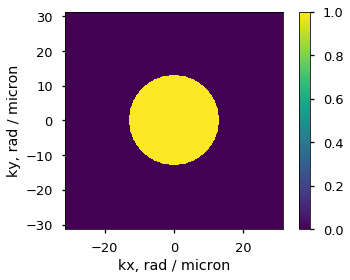

In [4]:
maskRadius = kNA / dk # Radius of amplitude mask for defining the pupil
maskCenter = np.floor(imgSize / 2)
W, H       = np.meshgrid(np.arange(0, imgSize), np.arange(0, imgSize))
mask       = 1.0*(np.sqrt((W - maskCenter)**2 + (H- maskCenter)**2) < maskRadius)

img = plt.imshow(mask, extent = (kx.min(), kx.max(), ky.min(), ky.max()))
plt.xlabel('kx, rad / micron')
plt.ylabel('ky, rad / micron')
plt.colorbar(img)
plt.show()

In [5]:
amp   = np.ones((imgSize, imgSize)) * mask
phase = 2j * np.pi * np.ones((imgSize, imgSize))
pupil = amp * np.exp(phase)

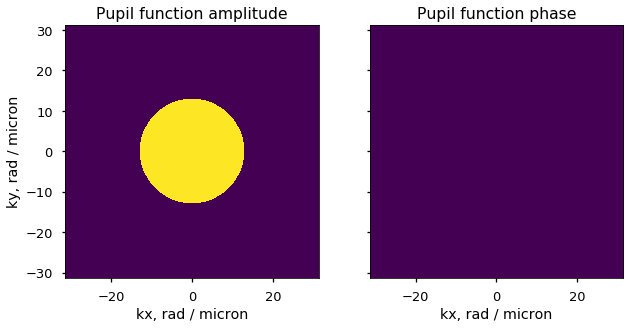

In [6]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10,6))
img0 = ax0.imshow(amp, extent = ((kx.min(), kx.max(), ky.min(), ky.max())))
ax0.set_title('Pupil function amplitude')
ax0.set_xlabel('kx, rad / micron')
ax0.set_ylabel('ky, rad / micron')

img1 = ax1.imshow(np.imag(phase), extent = ((kx.min(), kx.max(), ky.min(), ky.max())))
ax1.set_title('Pupil function phase')
ax1.set_xlabel('kx, rad / micron')
plt.show()

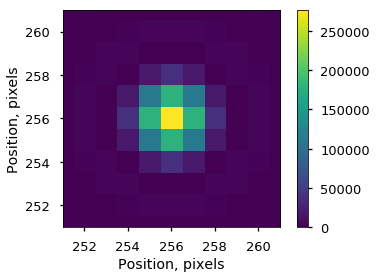

In [7]:
psfA_Unaberrated = fftshift(fft2(ifftshift(pupil))) * dk**2
psf              = psfA_Unaberrated * np.conj(psfA_Unaberrated) # PSFA times its complex conjugate

zoomWidth = 5 # pixels

# It is important to set interpolation to 'nearest' to prevent smoothing
img = plt.imshow(np.real(psf), interpolation = 'nearest')
plt.xlim((np.floor(imgSize / 2) - zoomWidth, np.floor(imgSize / 2) + zoomWidth))
plt.ylim((np.floor(imgSize / 2) - zoomWidth, np.floor(imgSize / 2) + zoomWidth))
plt.xlabel('Position, pixels')
plt.ylabel('Position, pixels')
plt.colorbar(img)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


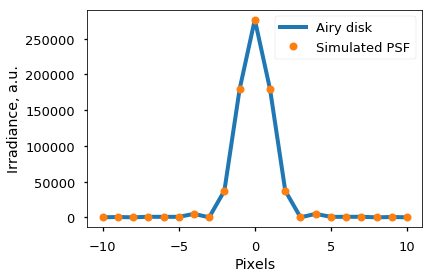

In [8]:
from scipy.special import j1 as bessel1
px   = np.arange(-10, 11) # pixels
x    = 2 * np.pi * px * NA * pixelSize / wavelength 
airy = np.max(np.real(psf)) * (2 * bessel1(x) / x)**2

# Fix point at x = 0 where divide-by-zero occurred
airy[int(np.floor(x.size / 2))] = np.max(np.real(psf))

# Take a line profile through the center of the simulated PSF
lineProfile = np.real(psf[int(np.floor(imgSize / 2)), int(np.floor(imgSize / 2) - 10) : int(np.floor(imgSize / 2) + 11)])

plt.plot(px, airy,             linewidth = 4,  label = 'Airy disk')
plt.plot(px, lineProfile, 'o', markersize = 8, label = 'Simulated PSF')
plt.xlabel('Pixels')
plt.ylabel('Irradiance, a.u.')
plt.legend()
plt.show()

In [9]:
# Defocus from -1 micron to + 1 micron
defocusDistance = np.arange(-1, 1.1, 0.1)
defocusPSF      = np.zeros((imgSize, imgSize, defocusDistance.size))

for ctr, z in enumerate(defocusDistance):
    # Add 0j to ensure that np.sqrt knows that its argument is complex
    defocusPhaseAngle   = 1j * z * np.sqrt((2 * np.pi * nImmersion / wavelength)**2 - KX**2 - KY**2 + 0j)
    defocusKernel       = np.exp(defocusPhaseAngle)
    defocusPupil        = pupil * defocusKernel
    defocusPSFA         = fftshift(fft2(ifftshift(defocusPupil))) * dk**2
    defocusPSF[:,:,ctr] = np.real(defocusPSFA * np.conj(defocusPSFA))

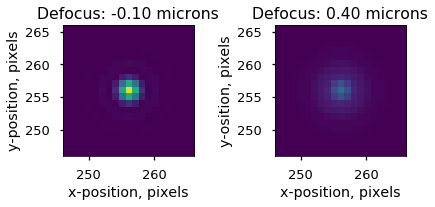

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

zoomWidth = 20 # pixels
indx      = [9, 14] # indexes to defocus distances to plot

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
maxIrradiance = np.max(defocusPSF[:,:,10])

ax0.imshow(defocusPSF[:, :, indx[0]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax0.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_xlabel('x-position, pixels')
ax0.set_ylabel('y-position, pixels')
ax0.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax1.imshow(defocusPSF[:, :, indx[1]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax1.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_xlabel('x-position, pixels')
ax1.set_ylabel('y-osition, pixels')
ax1.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))
plt.tight_layout()
plt.show()